In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [120]:
import functools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimpy
import time
import gc
import pandas as pd
from contextlib import contextmanager
from pathlib import Path
sns.set()

figure_path = Path("/home/tdimson/projects/cs348k/project/checkpoint")

In [128]:
class Timer:
    def __init__(self):
        self.duration_ns = None
        self.start_ns = None

    def __enter__(self, *args):
        gc.disable()
        self.start_ns = time.perf_counter_ns()

    def __exit__(self, type, value, traceback):
        self.duration_ns = time.perf_counter_ns() - self.start_ns
        gc.enable()
        
    @classmethod
    def repeated_average(cls, code, count):
        total_time = 0
        for i in range(count):
            total_time += code()
        return total_time / count
    
    @classmethod
    def repeated_median(cls, code, count):
        times = []
        for i in range(count):
            times.append(code())
        return sorted(times)[len(times) // 2]
        

def numpy_banded_gradient(n, n_ops, band_length):
    base = np.repeat(np.arange(n // band_length), band_length)
    t = Timer()
    with t:
        _ = functools.reduce(lambda x, y: x * base, range(n_ops), base)
    return t.duration_ns


def skimpy_banded_gradient(n, n_ops, band_length):
    base = skimpy.from_numpy(np.repeat(np.arange(n // band_length), band_length))
    t = Timer()
    with t:
        _ = functools.reduce(lambda x, y: x * base, range(n_ops), base).eval()
    return t.duration_ns


def numpy_dense(n, n_ops):
    base = np.ones(n, dtype=np.int32)
    multiplier = np.random.randint(2 ** 3, size=n)
    t = Timer()
    with t:
        _ = functools.reduce(lambda x, y: x * multiplier, range(n_ops), base)
    return t.duration_ns
    

def skimpy_dense(n, n_ops):
    base_np = np.ones(n)
    multiplier_np = np.random.randint(2 ** 3 - 1, size=n)
    base_skimpy = skimpy.from_numpy(base_np)
    multiplier_skimpy = skimpy.from_numpy(multiplier_np)
    
    
    t = Timer()
    with t:
        _ = functools.reduce(lambda x, y: x * multiplier_skimpy, range(n_ops), base_skimpy).eval()
        
    return t.duration_ns

def plot_array_performance(
    xs=[],
    numpys=[],
    skimpys=[],
    title=None,
    output_path=None,
):
    current_palette = sns.color_palette()
    fig1, ax1 = plt.subplots(figsize=(8, 6))

    for i, (label, values) in enumerate(numpys):            
        line_style = "--" if i == 1 else None
        plt.plot(xs, values, label=label, linestyle=line_style, color=current_palette[0], linewidth=2)
        
    for i, (label, values) in enumerate(skimpys):            
        line_style = "--" if i == 1 else None
        plt.plot(xs, values, label=label, linestyle=line_style, color=current_palette[1], linewidth=2)
        
    plt.ylabel("Wall time (ms)")
    plt.xlabel("Array size")
    if title:
        plt.title(title)
    plt.xscale("log")
    plt.yscale("log")
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.1f}" if x < 1 else f"{x:.0f}"))
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    
    if output_path:
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
    plt.show()

In [131]:
n = np.logspace(8, 22, base=2).astype(int)
n_average = 5
n_ops = 16
ns_to_ms = 1.0 / 1000000

numpy_4_times = np.array([
    Timer.repeated_average(code=lambda: numpy_dense(e, 4), count=n_average) * ns_to_ms 
    for e in n
])
numpy_16_times = np.array([
    Timer.repeated_average(code=lambda: numpy_dense(e, 16), count=n_average) * ns_to_ms 
    for e in n
])

skimpy_4_times = np.array([
    Timer.repeated_average(code=lambda: skimpy_dense(e, 4), count=n_average) * ns_to_ms 
    for e in n
])
skimpy_16_times = np.array([
    Timer.repeated_average(code=lambda: skimpy_dense(e, 16), count=n_average) * ns_to_ms 
    for e in n
])

In [139]:
(skimpy_16_times / numpy_16_times)[-9:]

array([5.53114354, 6.05109315, 5.5941119 , 4.78176516, 5.7190361 ,
       5.53698669, 5.54410955, 5.79244154, 4.59243748])

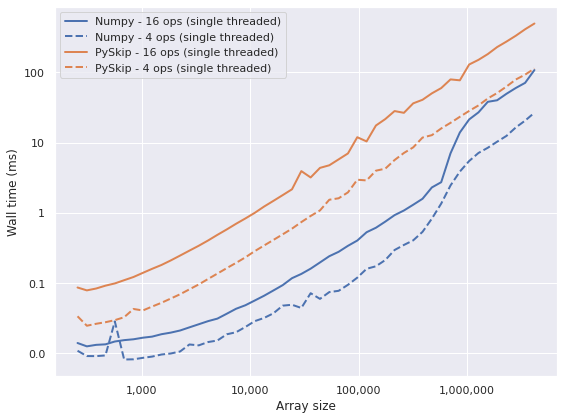

In [143]:
plot_array_performance(
    n, [
        ("Numpy - 16 ops (single threaded)", numpy_16_times),
        ("Numpy - 4 ops (single threaded)", numpy_4_times),
    ], [
        ("PySkip - 16 ops (single threaded)", skimpy_16_times),
        ("PySkip - 4 ops (single threaded)", skimpy_4_times),
    ],
    # title="Dense Array Performance (log-log)",
    title=None,
    output_path=(figure_path / "dense_array.png"),
)

In [133]:
n = np.logspace(8, 22, base=2).astype(int)
n_average = 5
ns_to_ms = 1.0 / 1000000
band_length = 100

numpy_4_times_rle = np.array([
    Timer.repeated_average(code=lambda: numpy_banded_gradient(e, 4, band_length), count=n_average) * ns_to_ms 
    for e in n
])
numpy_16_times_rle = np.array([
    Timer.repeated_average(code=lambda: numpy_banded_gradient(e, 16, band_length), count=n_average) * ns_to_ms 
    for e in n
])

skimpy_4_times_rle = np.array([
    Timer.repeated_average(code=lambda: skimpy_banded_gradient(e, 4, band_length), count=n_average) * ns_to_ms 
    for e in n
])
skimpy_16_times_rle = np.array([
    Timer.repeated_average(code=lambda: skimpy_banded_gradient(e, 16, band_length), count=n_average) * ns_to_ms 
    for e in n
])

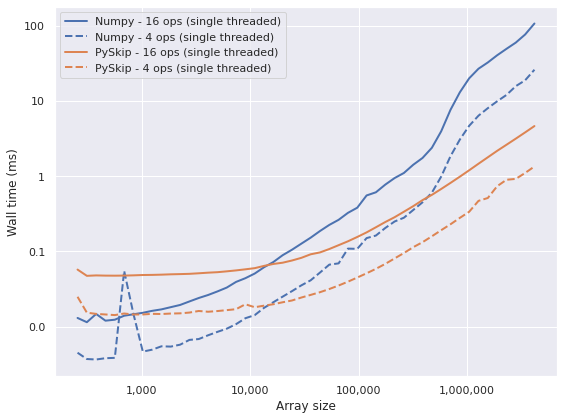

In [142]:
plot_array_performance(
    n, [
        ("Numpy - 16 ops (single threaded)", numpy_16_times_rle),
        ("Numpy - 4 ops (single threaded)", numpy_4_times_rle),
    ], [
        ("PySkip - 16 ops (single threaded)", skimpy_16_times_rle),
        ("PySkip - 4 ops (single threaded)", skimpy_4_times_rle),
    ],
    # title="Banded Gradient Array Performance (band width=100, log-log)",
    title=None,
    output_path=(figure_path / "rle_array.png"),
)

In [155]:
import skimpy as pyskip

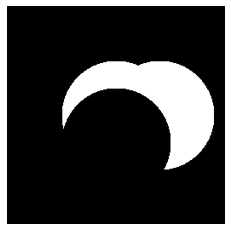

In [180]:
size, radius = 256, 256 // 4
builder = pyskip.IntArrayBuilder(size ** 2, 0)
for y in range(size):
    for x in range(size):
        if (x - size // 2)**2 + (y - size // 2)**2 < radius ** 2:
            builder[size * y + x] = 1
            
disc = builder.build()
shift_x = disc.clone()
shift_x[size // 5:] = disc[:-(size // 5)]
shift_y = disc.clone()
shift_y[size // 8 * size:] = disc[:-size // 8 * size]
scene = ((disc | shift_x) & ~shift_y).eval()

plt.imshow(scene.to_numpy().reshape(size, size), cmap="gray")

plt.axis('off')

plt.savefig(figure_path / "csg.png", dpi=300)